### From Paper to Code: Understanding and Reproducing "NeRF: Representing Scenes as Neural Radiance Fields for View Synthesis"
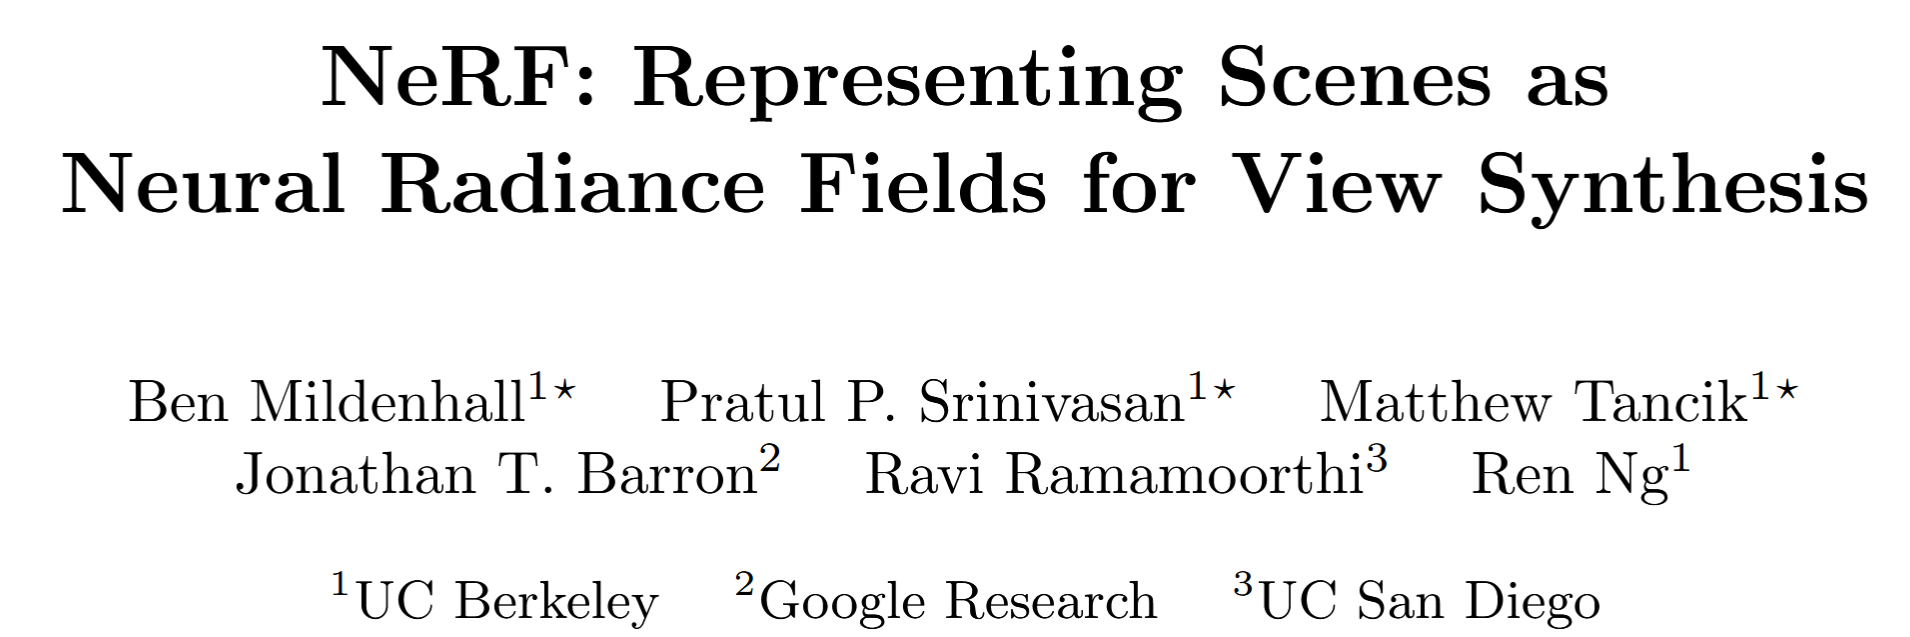
Code: [GitHub Repository(Tnsorflow)](https://github.com/bmild/nerf), [GitHub Repository(Pytorch)](https://github.com/yenchenlin/nerf-pytorch)
Source Code in My Repo: ../../../code/NeRF/nerf-pytorch-master/run_nerf.py

# Paper Reading Notes

## 1. Highlights

Inspired by SIREN(https://www.vincentsitzmann.com/siren/), we represent 3D scenes as a consistent function, instead of relying on discrete geometry or voxel-based representations. We use a simple, fully-connected MLP that models complex scenes as continuous neural radiance fields, a differentiable volume rendering technique that allows training from 2D images without any 3D supervision.


## 2. Background

Novel view synthesis — generating new images of a 3D scene from a sparse set of captured views — is a long-standing challenge in computer vision and computer graphics.

Traditional approaches rely on:
- Explicit 3D reconstruction (point clouds, voxel grids, triangle meshes),
- Or dense view interpolation (light fields) which requires heavy sampling,
- Or multi-view stereo, which struggles under non-Lambertian materials or occlusions.

Recent deep learning methods have proposed:
- Implicit neural scene representations, such as Occupancy Networks [1] and DeepSDF [2], mapping coordinates to occupancy or signed distance fields,
- Voxel-based neural rendering, such as DeepVoxels [3],
- Image-based interpolation methods, like Local Light Field Fusion (LLFF) [4].

However, existing techniques often suffer from either:
- The need for ground-truth 3D geometry,
- Limited ability to capture fine details,
- Or high memory and computational costs for high-resolution modeling.


## 3. Method Overview

The key idea of NeRF is simple but powerful:

> Represent a 3D scene as a continuous volumetric field using a multilayer perceptron (MLP).

Specifically:
- Input: a 5D coordinate $(x, y, z, \theta, \phi)$, or a 3D position $x$ and 2D viewing direction $d$.
- Output: the volume density $\sigma$ and RGB color $c=(r,g,b)$ at that point and direction.

To render a novel view, NeRF traces rays from the virtual camera, samples 3D points along each ray, queries the network, and integrates their contributions using volume rendering.

The rendering equation is:

$$
C(r) = \int_{t_n}^{t_f} T(t) \, \sigma(r(t)) \, c(r(t), d) \, dt
$$

where transmittance $T(t)$ is:

$$
T(t) = \exp\left( -\int_{t_n}^{t} \sigma(r(s))\, ds \right)
$$

The integral is numerically estimated using stratified sampling and quadrature.

Further improvements include:
- Positional encoding: mapping coordinates to a higher dimensional space with sinusoidal functions to better represent high-frequency details,
- Hierarchical volume sampling: using a coarse-to-fine strategy to focus computational effort where density is high.

Because the entire rendering process is differentiable, the network can be optimized end-to-end using only RGB images and known camera poses.


---

## References

[1] Lars Mescheder, Michael Oechsle, Michael Niemeyer, Sebastian Nowozin, Andreas Geiger.  
"Occupancy Networks: Learning 3D Reconstruction in Function Space."  
Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition (CVPR), 2019.

[2] Jeong Joon Park, Peter Florence, Julian Straub, Richard Newcombe, Steven Lovegrove.  
"DeepSDF: Learning Continuous Signed Distance Functions for Shape Representation."  
Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition (CVPR), 2019.

[3] Vincent Sitzmann, Justus Thies, Felix Heide, Matthias Nießner, Gordon Wetzstein, Michael Zollhöfer.  
"DeepVoxels: Learning Persistent 3D Feature Embeddings."  
Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition (CVPR), 2019.

[4] Ben Mildenhall, Pratul P. Srinivasan, Rodrigo Ortiz-Cayon, Nima Khademi Kalantari, Ravi Ramamoorthi, Ren Ng, Abhishek Kar.  
"Local Light Field Fusion: Practical View Synthesis with Prescriptive Sampling Guidelines."  
ACM Transactions on Graphics (TOG), Proceedings of SIGGRAPH, 2019.



Corresponding code: code/NeRF/nerf-pytorch-master/run_nerf.py

# Code Reproduction with Explanation

In [1]:
import sys
import os

current_dir = os.path.dirname(os.path.abspath("__file__")) if "__file__" in locals() else os.getcwd()
gs_code_dir = os.path.abspath(os.path.join(current_dir, '../../../code/NeRF/nerf-pytorch-master'))
if gs_code_dir not in sys.path:
    sys.path.append(gs_code_dir)

print(f"✅ Added {gs_code_dir} to sys.path")

import numpy as np
import imageio
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm, trange

import matplotlib.pyplot as plt

from run_nerf_helpers import *

from load_llff import load_llff_data
from load_deepvoxels import load_dv_data
from load_blender import load_blender_data
from load_LINEMOD import load_LINEMOD_data


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
np.random.seed(0)
DEBUG = False
torch.set_default_tensor_type('torch.cuda.FloatTensor')

✅ Added /home/xqgao/2025/MIT/code/NeRF/nerf-pytorch-master to sys.path


/home/xqgao/anaconda3/envs/inr/lib/python3.12/site-packages/torch/__init__.py:1144: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647329220/work/torch/csrc/tensor/python_tensor.cpp:432.)
  _C._set_default_tensor_type(t)


At first, `batchify` allows us to handle large datasets by processing them in smaller, manageable pieces, helping to avoid memory overflow.

In [2]:
def batchify(fn, chunk):
    """Constructs a version of 'fn' that applies to smaller batches.
    """
    if chunk is None:
        return fn
    def ret(inputs):
        return torch.cat([fn(inputs[i:i+chunk]) for i in range(0, inputs.shape[0], chunk)], 0)
    return ret

def batchify_rays(rays_flat, chunk=1024*32, kwargs):
    """Render rays in smaller minibatches to avoid OOM.
    """
    all_ret = {}
    for i in range(0, rays_flat.shape[0], chunk):
        ret = render_rays(rays_flat[i:i+chunk], kwargs)
        for k in ret:
            if k not in all_ret:
                all_ret[k] = []
            all_ret[k].append(ret[k])

    all_ret = {k : torch.cat(all_ret[k], 0) for k in all_ret}
    return all_ret


The `run_network` function processes 3D coordinates (or `pose`) and viewing directions through a neural network.

As for `embed_fn`, when the input image is 256×256, we sample one ray per pixel, resulting in 256×256 = 65536 rays. Each ray corresponds to a 3D point, so the input to the embedder has shape `[65536, 3]`. When `multires=10`, the embedder applies 10 sine and 10 cosine functions to each coordinate, plus the original input. This gives 21 functions per coordinate, and 21 × 3 = 63 dimensions per point. The embedded output has shape `[65536, 63]`.

If viewing directions (`viewdirs`) are provided, they are also embedded using the same approach.

In [3]:
def run_network(inputs, viewdirs, fn, embed_fn, embeddirs_fn, netchunk=1024*64):
    """Prepares inputs and applies network 'fn'.
    """
    inputs_flat = torch.reshape(inputs, [-1, inputs.shape[-1]])
    embedded = embed_fn(inputs_flat)

    if viewdirs is not None:
        input_dirs = viewdirs[:,None].expand(inputs.shape)
        input_dirs_flat = torch.reshape(input_dirs, [-1, input_dirs.shape[-1]])
        embedded_dirs = embeddirs_fn(input_dirs_flat)
        embedded = torch.cat([embedded, embedded_dirs], -1)

    outputs_flat = batchify(fn, netchunk)(embedded)
    outputs = torch.reshape(outputs_flat, list(inputs.shape[:-1]) + [outputs_flat.shape[-1]])
    return outputs

Next, The `render` function takes rays or camera poses and outputs predicted rgb, disparity, and opacity by calling `batchify_rays`, which runs the network on all rays in chunks.

The `render_path` function loops over a sequence of poses, calls `render` for each, and collects the rendered images.
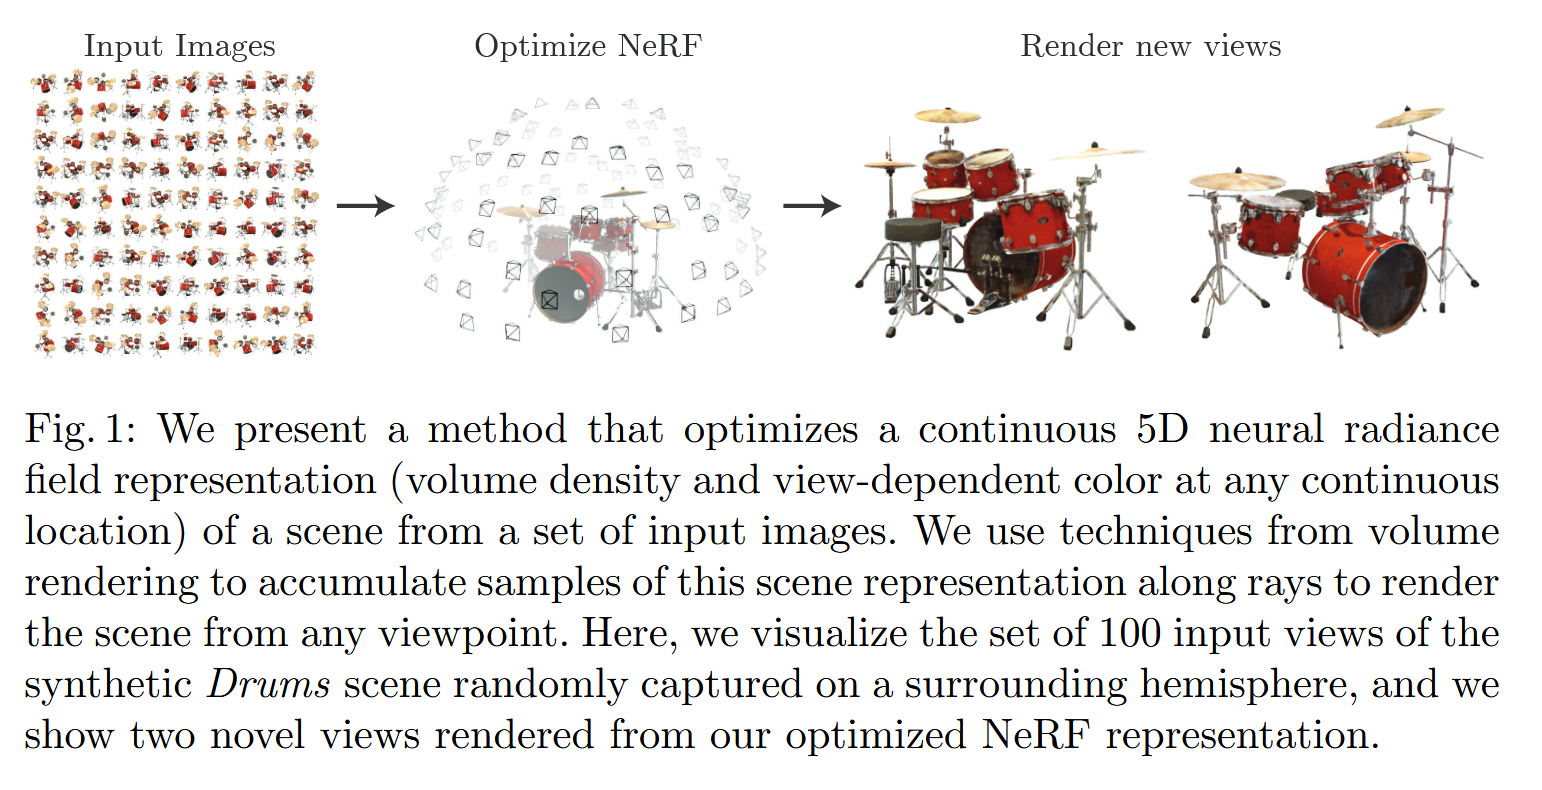
As shown in Fig. 1, we input the pose and coordinates, with the target being a 2D image that corresponds to the scene rendered from the specific camera pose. NeRF learns to map the input to the target in a supervised manner.

In [4]:
def render(H, W, K, chunk=1024*32, rays=None, c2w=None, ndc=True,
                  near=0., far=1.,
                  use_viewdirs=False, c2w_staticcam=None,
                  kwargs):
    """Render rays
    Args:
      H: int. Height of image in pixels.
      W: int. Width of image in pixels.
      focal: float. Focal length of pinhole camera.
      chunk: int. Maximum number of rays to process simultaneously. Used to
        control maximum memory usage. Does not affect final results.
      rays: array of shape [2, batch_size, 3]. Ray origin and direction for
        each example in batch.
      c2w: array of shape [3, 4]. Camera-to-world transformation matrix.
      ndc: bool. If True, represent ray origin, direction in NDC coordinates.
      near: float or array of shape [batch_size]. Nearest distance for a ray.
      far: float or array of shape [batch_size]. Farthest distance for a ray.
      use_viewdirs: bool. If True, use viewing direction of a point in space in model.
      c2w_staticcam: array of shape [3, 4]. If not None, use this transformation matrix for 
       camera while using other c2w argument for viewing directions.
    Returns:
      rgb_map: [batch_size, 3]. Predicted RGB values for rays.
      disp_map: [batch_size]. Disparity map. Inverse of depth.
      acc_map: [batch_size]. Accumulated opacity (alpha) along a ray.
      extras: dict with everything returned by render_rays().
    """
    if c2w is not None:
        # special case to render full image
        rays_o, rays_d = get_rays(H, W, K, c2w)
    else:
        # use provided ray batch
        rays_o, rays_d = rays

    if use_viewdirs:
        # provide ray directions as input
        viewdirs = rays_d
        if c2w_staticcam is not None:
            # special case to visualize effect of viewdirs
            rays_o, rays_d = get_rays(H, W, K, c2w_staticcam)
        viewdirs = viewdirs / torch.norm(viewdirs, dim=-1, keepdim=True)
        viewdirs = torch.reshape(viewdirs, [-1,3]).float()

    sh = rays_d.shape # [..., 3]
    if ndc:
        # for forward facing scenes
        rays_o, rays_d = ndc_rays(H, W, K[0][0], 1., rays_o, rays_d)

    # Create ray batch
    rays_o = torch.reshape(rays_o, [-1,3]).float()
    rays_d = torch.reshape(rays_d, [-1,3]).float()

    near, far = near * torch.ones_like(rays_d[...,:1]), far * torch.ones_like(rays_d[...,:1])
    rays = torch.cat([rays_o, rays_d, near, far], -1)
    if use_viewdirs:
        rays = torch.cat([rays, viewdirs], -1)

    # Render and reshape
    all_ret = batchify_rays(rays, chunk, kwargs)
    for k in all_ret:
        k_sh = list(sh[:-1]) + list(all_ret[k].shape[1:])
        all_ret[k] = torch.reshape(all_ret[k], k_sh)

    k_extract = ['rgb_map', 'disp_map', 'acc_map']
    ret_list = [all_ret[k] for k in k_extract]
    ret_dict = {k : all_ret[k] for k in all_ret if k not in k_extract}
    return ret_list + [ret_dict]


def render_path(render_poses, hwf, K, chunk, render_kwargs, gt_imgs=None, savedir=None, render_factor=0):

    H, W, focal = hwf

    if render_factor!=0:
        # Render downsampled for speed
        H = H//render_factor
        W = W//render_factor
        focal = focal/render_factor

    rgbs = []
    disps = []

    t = time.time()
    for i, c2w in enumerate(tqdm(render_poses)):
        print(i, time.time() - t)
        t = time.time()
        rgb, disp, acc, _ = render(H, W, K, chunk=chunk, c2w=c2w[:3,:4], render_kwargs)
        rgbs.append(rgb.cpu().numpy())
        disps.append(disp.cpu().numpy())
        if i==0:
            print(rgb.shape, disp.shape)

        """
        if gt_imgs is not None and render_factor==0:
            p = -10. * np.log10(np.mean(np.square(rgb.cpu().numpy() - gt_imgs[i])))
            print(p)
        """

        if savedir is not None:
            rgb8 = to8b(rgbs[-1])
            filename = os.path.join(savedir, '{:03d}.png'.format(i))
            imageio.imwrite(filename, rgb8)


    rgbs = np.stack(rgbs, 0)
    disps = np.stack(disps, 0)

    return rgbs, disps

This is the key part, the `create_nerf` function initializes the NeRF model with embeddings, sets up the optimizer, and prepares the rendering functions. It optionally loads a checkpoint to resume training and returns the necessary arguments for training and testing.

In [5]:
def create_nerf(args):
    """Instantiate NeRF's MLP model.
    """
    embed_fn, input_ch = get_embedder(args.multires, args.i_embed)

    input_ch_views = 0
    embeddirs_fn = None
    if args.use_viewdirs:
        embeddirs_fn, input_ch_views = get_embedder(args.multires_views, args.i_embed)
    output_ch = 5 if args.N_importance > 0 else 4
    skips = [4]
    model = NeRF(D=args.netdepth, W=args.netwidth,
                 input_ch=input_ch, output_ch=output_ch, skips=skips,
                 input_ch_views=input_ch_views, use_viewdirs=args.use_viewdirs).to(device)
    grad_vars = list(model.parameters())

    model_fine = None
    if args.N_importance > 0:
        model_fine = NeRF(D=args.netdepth_fine, W=args.netwidth_fine,
                          input_ch=input_ch, output_ch=output_ch, skips=skips,
                          input_ch_views=input_ch_views, use_viewdirs=args.use_viewdirs).to(device)
        grad_vars += list(model_fine.parameters())

    network_query_fn = lambda inputs, viewdirs, network_fn : run_network(inputs, viewdirs, network_fn,
                                                                embed_fn=embed_fn,
                                                                embeddirs_fn=embeddirs_fn,
                                                                netchunk=args.netchunk)

    # Create optimizer
    optimizer = torch.optim.Adam(params=grad_vars, lr=args.lrate, betas=(0.9, 0.999))

    start = 0
    basedir = args.basedir
    expname = args.expname

    ##########################

    # Load checkpoints
    if args.ft_path is not None and args.ft_path!='None':
        ckpts = [args.ft_path]
    else:
        ckpts = [os.path.join(basedir, expname, f) for f in sorted(os.listdir(os.path.join(basedir, expname))) if 'tar' in f]

    print('Found ckpts', ckpts)
    if len(ckpts) > 0 and not args.no_reload and ckpts[-1]!='null':
        ckpt_path = ckpts[-1]
        print('Reloading from', ckpt_path)
        ckpt = torch.load(ckpt_path)

        start = ckpt['global_step']
        optimizer.load_state_dict(ckpt['optimizer_state_dict'])

        # Load model
        model.load_state_dict(ckpt['network_fn_state_dict'])
        if model_fine is not None:
            model_fine.load_state_dict(ckpt['network_fine_state_dict'])

    ##########################

    render_kwargs_train = {
        'network_query_fn' : network_query_fn,
        'perturb' : args.perturb,
        'N_importance' : args.N_importance,
        'network_fine' : model_fine,
        'N_samples' : args.N_samples,
        'network_fn' : model,
        'use_viewdirs' : args.use_viewdirs,
        'white_bkgd' : args.white_bkgd,
        'raw_noise_std' : args.raw_noise_std,
    }

    # NDC only good for LLFF-style forward facing data
    if args.dataset_type != 'llff' or args.no_ndc:
        print('Not ndc!')
        render_kwargs_train['ndc'] = False
        render_kwargs_train['lindisp'] = args.lindisp

    render_kwargs_test = {k : render_kwargs_train[k] for k in render_kwargs_train}
    render_kwargs_test['perturb'] = False
    render_kwargs_test['raw_noise_std'] = 0.

    return render_kwargs_train, render_kwargs_test, start, grad_vars, optimizer

In [6]:
def config_parser():

    import configargparse
    parser = configargparse.ArgumentParser()
    parser.add_argument('--config', is_config_file=True, 
                        help='config file path')
    parser.add_argument("--expname", type=str, 
                        help='experiment name')
    parser.add_argument("--basedir", type=str, default='../../../code/NeRF/nerf-pytorch-master/logs/', 
                        help='where to store ckpts and logs')
    parser.add_argument("--datadir", type=str, default='../../../Datasets/NeRF/nerf_llff_data/fern/', 
                        help='input data directory')

    # training options
    parser.add_argument("--netdepth", type=int, default=8, 
                        help='layers in network')
    parser.add_argument("--netwidth", type=int, default=256, 
                        help='channels per layer')
    parser.add_argument("--netdepth_fine", type=int, default=8, 
                        help='layers in fine network')
    parser.add_argument("--netwidth_fine", type=int, default=256, 
                        help='channels per layer in fine network')
    parser.add_argument("--N_rand", type=int, default=32*32*4, 
                        help='batch size (number of random rays per gradient step)')
    parser.add_argument("--lrate", type=float, default=5e-4, 
                        help='learning rate')
    parser.add_argument("--lrate_decay", type=int, default=250, 
                        help='exponential learning rate decay (in 1000 steps)')
    parser.add_argument("--chunk", type=int, default=1024*32, 
                        help='number of rays processed in parallel, decrease if running out of memory')
    parser.add_argument("--netchunk", type=int, default=1024*64, 
                        help='number of pts sent through network in parallel, decrease if running out of memory')
    parser.add_argument("--no_batching", action='store_true', 
                        help='only take random rays from 1 image at a time')
    parser.add_argument("--no_reload", action='store_true', 
                        help='do not reload weights from saved ckpt')
    parser.add_argument("--ft_path", type=str, default=None, 
                        help='specific weights npy file to reload for coarse network')

    # rendering options
    parser.add_argument("--N_samples", type=int, default=64, 
                        help='number of coarse samples per ray')
    parser.add_argument("--N_importance", type=int, default=0,
                        help='number of additional fine samples per ray')
    parser.add_argument("--perturb", type=float, default=1.,
                        help='set to 0. for no jitter, 1. for jitter')
    parser.add_argument("--use_viewdirs", action='store_true', 
                        help='use full 5D input instead of 3D')
    parser.add_argument("--i_embed", type=int, default=0, 
                        help='set 0 for default positional encoding, -1 for none')
    parser.add_argument("--multires", type=int, default=10, 
                        help='log2 of max freq for positional encoding (3D location)')
    parser.add_argument("--multires_views", type=int, default=4, 
                        help='log2 of max freq for positional encoding (2D direction)')
    parser.add_argument("--raw_noise_std", type=float, default=0., 
                        help='std dev of noise added to regularize sigma_a output, 1e0 recommended')

    parser.add_argument("--render_only", action='store_true', 
                        help='do not optimize, reload weights and render out render_poses path')
    parser.add_argument("--render_test", action='store_true', 
                        help='render the test set instead of render_poses path')
    parser.add_argument("--render_factor", type=int, default=0, 
                        help='downsampling factor to speed up rendering, set 4 or 8 for fast preview')

    # training options
    parser.add_argument("--precrop_iters", type=int, default=0,
                        help='number of steps to train on central crops')
    parser.add_argument("--precrop_frac", type=float,
                        default=.5, help='fraction of img taken for central crops') 

    # dataset options
    parser.add_argument("--dataset_type", type=str, default='llff', 
                        help='options: llff / blender / deepvoxels')
    parser.add_argument("--testskip", type=int, default=8, 
                        help='will load 1/N images from test/val sets, useful for large datasets like deepvoxels')

    ## deepvoxels flags
    parser.add_argument("--shape", type=str, default='greek', 
                        help='options : armchair / cube / greek / vase')

    ## blender flags
    parser.add_argument("--white_bkgd", action='store_true', 
                        help='set to render synthetic data on a white bkgd (always use for dvoxels)')
    parser.add_argument("--half_res", action='store_true', 
                        help='load blender synthetic data at 400x400 instead of 800x800')

    ## llff flags
    parser.add_argument("--factor", type=int, default=8, 
                        help='downsample factor for LLFF images')
    parser.add_argument("--no_ndc", action='store_true', 
                        help='do not use normalized device coordinates (set for non-forward facing scenes)')
    parser.add_argument("--lindisp", action='store_true', 
                        help='sampling linearly in disparity rather than depth')
    parser.add_argument("--spherify", action='store_true', 
                        help='set for spherical 360 scenes')
    parser.add_argument("--llffhold", type=int, default=8, 
                        help='will take every 1/N images as LLFF test set, paper uses 8')

    # logging/saving options
    parser.add_argument("--i_print",   type=int, default=100, 
                        help='frequency of console printout and metric loggin')
    parser.add_argument("--i_img",     type=int, default=500, 
                        help='frequency of tensorboard image logging')
    parser.add_argument("--i_weights", type=int, default=10000, 
                        help='frequency of weight ckpt saving')
    parser.add_argument("--i_testset", type=int, default=50000, 
                        help='frequency of testset saving')
    parser.add_argument("--i_video",   type=int, default=50000, 
                        help='frequency of render_poses video saving')

    return parser


In [7]:
parser = config_parser()
args = parser.parse_args([
    '--config', '../../../code/NeRF/nerf-pytorch-master/configs/lego.yaml'
])

# Load data
K = None
if args.dataset_type == 'llff':
    images, poses, bds, render_poses, i_test = load_llff_data(args.datadir, args.factor,
                                                                recenter=True, bd_factor=.75,
                                                                spherify=args.spherify)
    hwf = poses[0,:3,-1]
    poses = poses[:,:3,:4]
    print('Loaded llff', images.shape, render_poses.shape, hwf, args.datadir)
    if not isinstance(i_test, list):
        i_test = [i_test]

    if args.llffhold > 0:
        print('Auto LLFF holdout,', args.llffhold)
        i_test = np.arange(images.shape[0])[::args.llffhold]

    i_val = i_test
    i_train = np.array([i for i in np.arange(int(images.shape[0])) if
                    (i not in i_test and i not in i_val)])

    print('DEFINING BOUNDS')
    if args.no_ndc:
        near = np.ndarray.min(bds) * .9
        far = np.ndarray.max(bds) * 1.
        
    else:
        near = 0.
        far = 1.
    print('NEAR FAR', near, far)

elif args.dataset_type == 'blender':
    images, poses, render_poses, hwf, i_split = load_blender_data(args.datadir, args.half_res, args.testskip)
    print('Loaded blender', images.shape, render_poses.shape, hwf, args.datadir)
    i_train, i_val, i_test = i_split

    near = 2.
    far = 6.

    if args.white_bkgd:
        images = images[...,:3]*images[...,-1:] + (1.-images[...,-1:])
    else:
        images = images[...,:3]

elif args.dataset_type == 'LINEMOD':
    images, poses, render_poses, hwf, K, i_split, near, far = load_LINEMOD_data(args.datadir, args.half_res, args.testskip)
    print(f'Loaded LINEMOD, images shape: {images.shape}, hwf: {hwf}, K: {K}')
    print(f'[CHECK HERE] near: {near}, far: {far}.')
    i_train, i_val, i_test = i_split

    if args.white_bkgd:
        images = images[...,:3]*images[...,-1:] + (1.-images[...,-1:])
    else:
        images = images[...,:3]

elif args.dataset_type == 'deepvoxels':

    images, poses, render_poses, hwf, i_split = load_dv_data(scene=args.shape,
                                                                basedir=args.datadir,
                                                                testskip=args.testskip)

    print('Loaded deepvoxels', images.shape, render_poses.shape, hwf, args.datadir)
    i_train, i_val, i_test = i_split

    hemi_R = np.mean(np.linalg.norm(poses[:,:3,-1], axis=-1))
    near = hemi_R-1.
    far = hemi_R+1.

else:
    print('Unknown dataset type', args.dataset_type, 'exiting')
    # return

Loaded blender (138, 400, 400, 4) torch.Size([40, 4, 4]) [400, 400, 555.5555155968841] /home/xqgao/2025/MIT/Datasets/NeRF/nerf_synthetic/lego


In [8]:
# Cast intrinsics to right types
H, W, focal = hwf
H, W = int(H), int(W)
hwf = [H, W, focal]

if K is None:
    K = np.array([
        [focal, 0, 0.5*W],
        [0, focal, 0.5*H],
        [0, 0, 1]
    ])

if args.render_test:
    render_poses = np.array(poses[i_test])

# Create log dir and copy the config file
basedir = args.basedir
expname = args.expname
os.makedirs(os.path.join(basedir, expname), exist_ok=True)
f = os.path.join(basedir, expname, 'args.txt')
with open(f, 'w') as file:
    for arg in sorted(vars(args)):
        attr = getattr(args, arg)
        file.write('{} = {}\n'.format(arg, attr))
if args.config is not None:
    f = os.path.join(basedir, expname, 'config.txt')
    with open(f, 'w') as file:
        file.write(open(args.config, 'r').read())

# Create nerf model
render_kwargs_train, render_kwargs_test, start, grad_vars, optimizer = create_nerf(args)
global_step = start

bds_dict = {
    'near' : near,
    'far' : far,
}
render_kwargs_train.update(bds_dict)
render_kwargs_test.update(bds_dict)

# Move testing data to GPU
render_poses = torch.Tensor(render_poses).to(device)

Found ckpts ['/home/xqgao/2025/MIT/code/NeRF/nerf-pytorch-master/pre_trained_models/lego_test/200000.tar']
Reloading from /home/xqgao/2025/MIT/code/NeRF/nerf-pytorch-master/pre_trained_models/lego_test/200000.tar
Not ndc!


/tmp/ipykernel_562082/714444991.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path)


In [9]:
# Short circuit if only rendering out from trained model
if args.render_only:
    print('RENDER ONLY')
    with torch.no_grad():
        if args.render_test:
            # render_test switches to test poses
            images = images[i_test]
        else:
            # Default is smoother render_poses path
            images = None

        testsavedir = os.path.join(basedir, expname, 'renderonly_{}_{:06d}'.format('test' if args.render_test else 'path', start))
        os.makedirs(testsavedir, exist_ok=True)
        print('test poses shape', render_poses.shape)

        rgbs, _ = render_path(render_poses, hwf, K, args.chunk, render_kwargs_test, gt_imgs=images, savedir=testsavedir, render_factor=args.render_factor)
        print('Done rendering', testsavedir)
        imageio.mimwrite(os.path.join(testsavedir, 'video.mp4'), to8b(rgbs), fps=30, quality=8)

        # return

There is optimazation loop.

In [10]:
# Prepare raybatch tensor if batching random rays
N_rand = args.N_rand
use_batching = not args.no_batching
if use_batching:
    # For random ray batching
    print('get rays')
    rays = np.stack([get_rays_np(H, W, K, p) for p in poses[:,:3,:4]], 0) # [N, ro+rd, H, W, 3]
    print('done, concats')
    rays_rgb = np.concatenate([rays, images[:,None]], 1) # [N, ro+rd+rgb, H, W, 3]
    rays_rgb = np.transpose(rays_rgb, [0,2,3,1,4]) # [N, H, W, ro+rd+rgb, 3]
    rays_rgb = np.stack([rays_rgb[i] for i in i_train], 0) # train images only
    rays_rgb = np.reshape(rays_rgb, [-1,3,3]) # [(N-1)*H*W, ro+rd+rgb, 3]
    rays_rgb = rays_rgb.astype(np.float32)
    print('shuffle rays')
    np.random.shuffle(rays_rgb)

    print('done')
    i_batch = 0

# Move training data to GPU
if use_batching:
    images = torch.Tensor(images).to(device)
poses = torch.Tensor(poses).to(device)
if use_batching:
    rays_rgb = torch.Tensor(rays_rgb).to(device)


N_iters = 200000 + 1
print('Begin')
print('TRAIN views are', i_train)
print('TEST views are', i_test)
print('VAL views are', i_val)

# Summary writers
# writer = SummaryWriter(os.path.join(basedir, 'summaries', expname))

start = start + 1
for i in trange(start, N_iters):
    time0 = time.time()

    # Sample random ray batch
    if use_batching:
        # Random over all images
        batch = rays_rgb[i_batch:i_batch+N_rand] # [B, 2+1, 3*?]
        batch = torch.transpose(batch, 0, 1)
        batch_rays, target_s = batch[:2], batch[2]

        i_batch += N_rand
        if i_batch >= rays_rgb.shape[0]:
            print("Shuffle data after an epoch!")
            rand_idx = torch.randperm(rays_rgb.shape[0])
            rays_rgb = rays_rgb[rand_idx]
            i_batch = 0

    else:
        # Random from one image
        img_i = np.random.choice(i_train)
        target = images[img_i]
        target = torch.Tensor(target).to(device)
        pose = poses[img_i, :3,:4]

        if N_rand is not None:
            rays_o, rays_d = get_rays(H, W, K, torch.Tensor(pose))  # (H, W, 3), (H, W, 3)
            if i < args.precrop_iters:
                dH = int(H//2 * args.precrop_frac)
                dW = int(W//2 * args.precrop_frac)
                coords = torch.stack(
                    torch.meshgrid(
                        torch.linspace(H//2 - dH, H//2 + dH - 1, 2*dH), 
                        torch.linspace(W//2 - dW, W//2 + dW - 1, 2*dW)
                    ), -1)
                if i == start:
                    print(f"[Config] Center cropping of size {2*dH} x {2*dW} is enabled until iter {args.precrop_iters}")                
            else:
                coords = torch.stack(torch.meshgrid(torch.linspace(0, H-1, H), torch.linspace(0, W-1, W)), -1)  # (H, W, 2)

            coords = torch.reshape(coords, [-1,2])  # (H * W, 2)
            select_inds = np.random.choice(coords.shape[0], size=[N_rand], replace=False)  # (N_rand,)
            select_coords = coords[select_inds].long()  # (N_rand, 2)
            rays_o = rays_o[select_coords[:, 0], select_coords[:, 1]]  # (N_rand, 3)
            rays_d = rays_d[select_coords[:, 0], select_coords[:, 1]]  # (N_rand, 3)
            batch_rays = torch.stack([rays_o, rays_d], 0)
            target_s = target[select_coords[:, 0], select_coords[:, 1]]  # (N_rand, 3)
            #1024,3rgb
    #####  Core optimization loop  #####
    rgb, disp, acc, extras = render(H, W, K, chunk=args.chunk, rays=batch_rays,
                                            verbose=i < 10, retraw=True,
                                            render_kwargs_train)

    optimizer.zero_grad()
    img_loss = img2mse(rgb, target_s)
    trans = extras['raw'][...,-1]
    loss = img_loss
    psnr = mse2psnr(img_loss)

    if 'rgb0' in extras:
        img_loss0 = img2mse(extras['rgb0'], target_s)
        loss = loss + img_loss0
        psnr0 = mse2psnr(img_loss0)

    loss.backward()
    optimizer.step()

    # NOTE: IMPORTANT!
    ###   update learning rate   ###
    decay_rate = 0.1
    decay_steps = args.lrate_decay * 1000
    new_lrate = args.lrate * (decay_rate  (global_step / decay_steps))
    for param_group in optimizer.param_groups:
        param_group['lr'] = new_lrate
    ################################

    dt = time.time()-time0
    # print(f"Step: {global_step}, Loss: {loss}, Time: {dt}")
    #####           end            #####

    # Rest is logging
    if i%args.i_weights==0:
        path = os.path.join(basedir, expname, '{:06d}.tar'.format(i))
        torch.save({
            'global_step': global_step,
            'network_fn_state_dict': render_kwargs_train['network_fn'].state_dict(),
            'network_fine_state_dict': render_kwargs_train['network_fine'].state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }, path)
        print('Saved checkpoints at', path)

    if i%args.i_video==0 and i > 0:
        # Turn on testing mode
        with torch.no_grad():
            rgbs, disps = render_path(render_poses, hwf, K, args.chunk, render_kwargs_test)
        print('Done, saving', rgbs.shape, disps.shape)
        moviebase = os.path.join(basedir, expname, '{}_spiral_{:06d}_'.format(expname, i))
        imageio.mimwrite(moviebase + 'rgb.mp4', to8b(rgbs), fps=30, quality=8)
        imageio.mimwrite(moviebase + 'disp.mp4', to8b(disps / np.max(disps)), fps=30, quality=8)

        # if args.use_viewdirs:
        #     render_kwargs_test['c2w_staticcam'] = render_poses[0][:3,:4]
        #     with torch.no_grad():
        #         rgbs_still, _ = render_path(render_poses, hwf, args.chunk, render_kwargs_test)
        #     render_kwargs_test['c2w_staticcam'] = None
        #     imageio.mimwrite(moviebase + 'rgb_still.mp4', to8b(rgbs_still), fps=30, quality=8)

    if i%args.i_testset==0 and i > 0:
        testsavedir = os.path.join(basedir, expname, 'testset_{:06d}'.format(i))
        os.makedirs(testsavedir, exist_ok=True)
        print('test poses shape', poses[i_test].shape)
        with torch.no_grad():
            render_path(torch.Tensor(poses[i_test]).to(device), hwf, K, args.chunk, render_kwargs_test, gt_imgs=images[i_test], savedir=testsavedir)
        print('Saved test set')



    if i%args.i_print==0:
        tqdm.write(f"[TRAIN] Iter: {i} Loss: {loss.item()}  PSNR: {psnr.item()}")
    """
        print(expname, i, psnr.numpy(), loss.numpy(), global_step.numpy())
        print('iter time {:.05f}'.format(dt))

        with tf.contrib.summary.record_summaries_every_n_global_steps(args.i_print):
            tf.contrib.summary.scalar('loss', loss)
            tf.contrib.summary.scalar('psnr', psnr)
            tf.contrib.summary.histogram('tran', trans)
            if args.N_importance > 0:
                tf.contrib.summary.scalar('psnr0', psnr0)


        if i%args.i_img==0:

            # Log a rendered validation view to Tensorboard
            img_i=np.random.choice(i_val)
            target = images[img_i]
            pose = poses[img_i, :3,:4]
            with torch.no_grad():
                rgb, disp, acc, extras = render(H, W, focal, chunk=args.chunk, c2w=pose,
                                                    render_kwargs_test)

            psnr = mse2psnr(img2mse(rgb, target))

            with tf.contrib.summary.record_summaries_every_n_global_steps(args.i_img):

                tf.contrib.summary.image('rgb', to8b(rgb)[tf.newaxis])
                tf.contrib.summary.image('disp', disp[tf.newaxis,...,tf.newaxis])
                tf.contrib.summary.image('acc', acc[tf.newaxis,...,tf.newaxis])

                tf.contrib.summary.scalar('psnr_holdout', psnr)
                tf.contrib.summary.image('rgb_holdout', target[tf.newaxis])


            if args.N_importance > 0:

                with tf.contrib.summary.record_summaries_every_n_global_steps(args.i_img):
                    tf.contrib.summary.image('rgb0', to8b(extras['rgb0'])[tf.newaxis])
                    tf.contrib.summary.image('disp0', extras['disp0'][tf.newaxis,...,tf.newaxis])
                    tf.contrib.summary.image('z_std', extras['z_std'][tf.newaxis,...,tf.newaxis])
    """

    global_step += 1

Begin
TRAIN views are [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]
TEST views are [113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130
 131 132 133 134 135 136 137]
VAL views are [100 101 102 103 104 105 106 107 108 109 110 111 112]


0it [00:00, ?it/s]
